# Assignment 2

This notebook is intended to produce the plots and figures for the report on Problem 1 of the practical. You should not run this notebook in Google Colab until you have finished constructing the correct solutions for transformer_solution.py and encoder_decoder_solution.py

This notebook provides some limited commentary on several HuggingFace Features and toolage. You will use HuggingFace Datasets to load the Amazon Polarity dataset for sentiment analysis. The notebook will define a Bert tokenizer, collate functions, and then train and evaluate several models using the HuggingFace utilities mentioned above. Remember, the most crucial part here is running the experiments for the report.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Mount your Google Drive

In [5]:
# # If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# # you can delete this cell which is specific to Google Colab. You may also
# # change the paths for data/logs in Arguments below.

# from google.colab import drive
# drive.mount('/content/gdrive')

!pip install -qqq datasets transformers textattack --upgrade

### Link your assignment folder & install requirements
Enter the path to the assignment folder in your Google Drive
If you run this notebook locally or on a cluster (i.e. not on Google Colab)
you can delete this cell which is specific to Google Colab. 

In [6]:
import sys
import os
import shutil
import warnings
import json
import lstm
import transformer

# folder = "" #@param {type:"string"}
# !ln -Ts "$folder" /content/assignment 2> /dev/null
# !cp gdrive/MyDrive/Assignment2/transformer.py .
# !cp gdrive/MyDrive/Assignment2/lstm.py .

# # Add the assignment folder to Python path
# if '/content/assignment' not in sys.path:
#   sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
# if not torch.cuda.is_available():
#   warnings.warn('CUDA is not available.')

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from sklearn.metrics import f1_score   
import time

from typing import List, Dict, Union, Optional, Tuple
import torch

from dataclasses import dataclass
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.auto import tqdm


from datasets import Dataset
import transformers

from datasets import load_dataset
from tokenizers import Tokenizer

from transformer import Transformer, MultiHeadedAttention
from lstm import EncoderDecoder

In [8]:
dataset_train = load_dataset("yelp_polarity", split="train", cache_dir="data/")
dataset_test = load_dataset("yelp_polarity", split="test[:1000]", cache_dir="data/")

### 🔍 Quick look at the data
Lets have quick look at a few samples in our test set.

In [9]:
n_samples_to_see = 3
for i in range(n_samples_to_see):
  print("-"*30)
  print("title:", dataset_test[i]["text"])
  print("label:", dataset_test[i]["label"])

------------------------------
title: Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years.
label: 1
------------------------------
title: Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \""fixed\"" it for free, and the very next morning I had the 

### 1️. Tokenize the `text`
Tokenize the `text`portion of each sample (i.e. parsing the text to smaller chunks). Tokenization can happen in many ways; traditionally, this was done based on the white spaces. With transformer-based models, tokenization is performed based on the frequency of occurrence of "chunk of text". This frequency can be learned in many different ways. However the most common one is the [**wordpiece**](https://arxiv.org/pdf/1609.08144v2.pdf) model. 
> The wordpiece model is generated using a data-driven approach to maximize the language-model likelihood
of the training data, given an evolving word definition. Given a training corpus and a number of desired
tokens $D$, the optimization problem is to select $D$ wordpieces such that the resulting corpus is minimal in the
number of wordpieces when segmented according to the chosen wordpiece model.

Under this model:
1. Not all things can be converted to tokens depending on the model. For example, most models have been pretrained without any knowledge of emojis. So their token will be `[UNK]`, which stands for unknown.
2. Some words will be mapped to multiple tokens!
3. Depending on the kind of model, your tokens may or may not respect capitalization

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
input_sample = "Welcome to IFT6135. We now teach you 🤗(HUGGING FACE) Library :DDD."
tokenizer.tokenize(input_sample)

['welcome',
 'to',
 'if',
 '##t',
 '##6',
 '##13',
 '##5',
 '.',
 'we',
 'now',
 'teach',
 'you',
 '[UNK]',
 '(',
 'hugging',
 'face',
 ')',
 'library',
 ':',
 'dd',
 '##d',
 '.']

### 2. Encoding
Once we have tokenized the text, we then need to convert these chuncks to numbers so we can feed them to our model. This conversion is basically a look-up in a dictionary **from `str` $\to$ `int`**. The tokenizer object can also perform this work. While it does so it will also add the *special* tokens needed by the model to the encodings. 

In [12]:
input_sample = "Welcome to IFT6135. We now teach you 🤗(HUGGING FACE) Library :DDD." #@param {type: "string"}

print("--> Token Encodings:\n",tokenizer.encode(input_sample), len(tokenizer.encode(input_sample)))
print("-."*15)
print("--> Token Encodings Decoded:\n",tokenizer.decode(tokenizer.encode(input_sample)))

--> Token Encodings:
 [101, 6160, 2000, 2065, 2102, 2575, 17134, 2629, 1012, 2057, 2085, 6570, 2017, 100, 1006, 17662, 2227, 1007, 3075, 1024, 20315, 2094, 1012, 102] 24
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
--> Token Encodings Decoded:
 [CLS] welcome to ift6135. we now teach you [UNK] ( hugging face ) library : ddd. [SEP]


### 3️. Truncate/Pad samples
Since all the sample in the batch will not have the same sequence length, we would need to truncate the longer sequences (i.e. the ones that exeed a predefined maximum length) and pad the shorter ones so we that we can equal length for all the samples in the batch. Once this is achieved, we would need to convert the result to `torch.Tensor`s and return. These tensors will then be retrieved from the [dataloader](https://https//pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [13]:
class Collate:
    def __init__(self, tokenizer: str, max_len: int) -> None:
        self.tokenizer_name = tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)
        self.max_len = max_len

    def __call__(self, batch: List[Dict[str, Union[str, int]]]) -> Dict[str, torch.Tensor]:
        texts = list(map(lambda batch_instance: batch_instance["text"], batch))
        tokenized_inputs = self.tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
            return_token_type_ids=False,
        )
        
        labels = list(map(lambda batch_instance: int(batch_instance["label"]), batch))
        labels = torch.LongTensor(labels)
        return dict(tokenized_inputs, **{"labels": labels})

#### 🧑‍🍳 Setting up the collate function

In [14]:
tokenizer_name = "bert-base-uncased"
sample_max_length = 256
collate = Collate(tokenizer=tokenizer_name, max_len=sample_max_length)

### 4. Models

In [15]:
from transformers import AutoModel
import torch.nn as nn
torch.random.manual_seed(0)

class ReviewClassifier(nn.Module):
    def __init__(self, backbone: str, backbone_hidden_size: int, nb_classes: int):
        super(ReviewClassifier, self).__init__()
        self.backbone = backbone
        self.backbone_hidden_size = backbone_hidden_size
        self.nb_classes = nb_classes
        self.back_bone = AutoModel.from_pretrained(
            self.backbone,
            output_attentions=False,
            output_hidden_states=False,
        )
        self.classifier = torch.nn.Linear(self.backbone_hidden_size, self.nb_classes)

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor, labels: Optional[torch.Tensor] = None
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        back_bone_output = self.back_bone(input_ids, attention_mask=attention_mask)
        hidden_states = back_bone_output[0]
        pooled_output = hidden_states[:, 0]  # getting the [CLS] token
        logits = self.classifier(pooled_output)
        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(
                logits.view(-1, self.nb_classes),
                labels.view(-1),
            )
            return loss, logits
        return logits

class ReviewClassifierLSTM(nn.Module):
    def __init__(self, nb_classes: int, encoder_only: bool = False, 
        with_attn: bool = True, dropout: int = 0.5, hidden_size: int = 256):
        super(ReviewClassifierLSTM, self).__init__()
        self.nb_classes = nb_classes
        self.encoder_only = encoder_only

        if with_attn:
            attn = MultiHeadedAttention(head_size = 2*hidden_size, num_heads=1)
        else:
            attn = None
            
        self.back_bone = EncoderDecoder(dropout=dropout, encoder_only=encoder_only,
                                        attn=attn, hidden_size=hidden_size)
        
        if self.encoder_only:
            self.classifier = torch.nn.Linear(hidden_size*2, self.nb_classes)
        else:
            self.classifier = torch.nn.Linear(hidden_size, self.nb_classes)
       
    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor, labels: Optional[torch.Tensor] = None
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        pooled_output, _ = self.back_bone(input_ids, attention_mask)
        logits = self.classifier(pooled_output)
        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(
                logits.view(-1, self.nb_classes),
                labels.view(-1),
            )
            return loss, logits
        return logits


class ReviewClassifierTransformer(nn.Module):
    def __init__(self, nb_classes: int, num_heads: int = 4, num_layers: int = 4, block: str="prenorm", dropout: float = 0.3):
        super(ReviewClassifierTransformer, self).__init__()
        self.nb_classes = nb_classes
        self.back_bone = Transformer(num_heads=num_heads, num_layers=num_layers, block=block, dropout=dropout)
        self.classifier = torch.nn.Linear(256, self.nb_classes)

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor, labels: Optional[torch.Tensor] = None
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # attention_mask = torch.cat([torch.ones(attention_mask.shape[0]).unsqueeze(1).to(device),
        #                             attention_mask], dim=1)
        back_bone_output = self.back_bone(input_ids, attention_mask)
        hidden_states = back_bone_output
        pooled_output = hidden_states
        logits = self.classifier(pooled_output)
        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(
                logits.view(-1, self.nb_classes),
                labels.view(-1),
            )
            return loss, logits
        return logits

### 5. Trainer

In [16]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"--> Device selected: {device}")
def train_one_epoch(
    model: torch.nn.Module, training_data_loader: DataLoader, optimizer: torch.optim.Optimizer, logging_frequency: int, testing_data_loader: DataLoader, logger: dict):
    model.train()
    optimizer.zero_grad()
    epoch_loss = 0
    logging_loss = 0
    start_time = time.time()
    mini_start_time = time.time()
    for step, batch in enumerate(training_data_loader):
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**batch)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        logging_loss += loss.item()

        if (step + 1) % logging_frequency == 0:
            freq_time = time.time()-mini_start_time
            logger['train_time'].append(freq_time+logger['train_time'][-1])
            logger['train_losses'].append(logging_loss/logging_frequency)
            print(f"Training loss @ step {step+1}: {logging_loss/logging_frequency}")
            eval_acc, eval_f1, eval_loss, eval_time = evaluate(model, testing_data_loader)
            logger['eval_accs'].append(eval_acc)
            logger['eval_f1s'].append(eval_f1)
            logger['eval_losses'].append(eval_loss)
            logger['eval_time'].append(eval_time+logger['eval_time'][-1])

            logging_loss = 0
            mini_start_time = time.time()

    return epoch_loss / len(training_data_loader), time.time()-start_time


def evaluate(model: torch.nn.Module, test_data_loader: DataLoader):
    model.eval()
    model.to(device)
    eval_loss = 0
    correct_predictions = {i: 0 for i in range(2)}
    total_predictions = {i: 0 for i in range(2)}
    preds = []
    targets = []
    start_time = time.time()
    with torch.no_grad():
        for step, batch in enumerate(test_data_loader):
            batch = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**batch)
            loss = outputs[0]
            eval_loss += loss.item()

            predictions = np.argmax(outputs[1].detach().cpu().numpy(), axis=1)
            preds.extend(predictions.tolist())
            targets.extend(batch["labels"].cpu().numpy().tolist())

            for target, prediction in zip(batch["labels"].cpu().numpy(), predictions):
                if target == prediction:
                    correct_predictions[target] += 1
                total_predictions[target] += 1
    accuracy = (100.0 * sum(correct_predictions.values())) / sum(total_predictions.values())
    f1 = f1_score(targets, preds)
    model.train()
    return accuracy, round(f1, 4), eval_loss / len(test_data_loader), time.time() - start_time


def save_logs(dictionary, log_dir, exp_id):
  log_dir = os.path.join(log_dir, exp_id)
  os.makedirs(log_dir, exist_ok=True)
  # Log arguments
  with open(os.path.join(log_dir, "args.json"), "w") as f:
    json.dump(dictionary, f, indent=2)

def save_model(model, log_dir, exp_id):
  log_dir = os.path.join(log_dir, exp_id)
  os.makedirs(log_dir, exist_ok=True)
  # Save model
  torch.save(model.state_dict(), f"models/model_{exp_id}.pt")

batch_size = 512

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate)

--> Device selected: mps


### 6. Problem 3
Feel free to modify this code however it is convenient for you to produce a report except for the model parameters.

In [ ]:
logging_frequency = 100
learning_rate = 1e-5
nb_epoch=3

for i in range(1, 9):
  experimental_setting = i

  if experimental_setting == 1:
    print("Setting 1: LSTM, no dropout, encoder only")
    model = ReviewClassifierLSTM(nb_classes=2, dropout=0, encoder_only=True)
  if experimental_setting == 2:
    print("Setting 2: LSTM, dropout, encoder only")
    model = ReviewClassifierLSTM(nb_classes=2, dropout=0.3, encoder_only=True)
  if experimental_setting == 3:
    print("Setting 3: LSTM, dropout, encoder-decoder, no attention")
    model = ReviewClassifierLSTM(nb_classes=2, dropout=0.3, encoder_only=False, with_attn=False)
  if experimental_setting == 4:
    print("Setting 4: LSTM, dropout, encoder-decoder, with attention")
    model = ReviewClassifierLSTM(nb_classes=2, dropout=0.3, encoder_only=False, with_attn=True)
  if experimental_setting == 5:
    print("Setting 5: Transformer, 2 layers, pre-normalization")
    model = ReviewClassifierTransformer(nb_classes=2, num_heads=4, num_layers=2, block='prenorm', dropout=0.3)
  if experimental_setting == 6:
    print("Setting 6: Transformer, 4 layers, pre-normalization")
    model = ReviewClassifierTransformer(nb_classes=2, num_heads=4, num_layers=4, block='prenorm', dropout=0.3)
  if experimental_setting == 7:
    print("Setting 7: Transformer, 2 layers, post-normalization")
    model = ReviewClassifierTransformer(nb_classes=2, num_heads=4, num_layers=2, block='postnorm', dropout=0.3)
  if experimental_setting == 8:
    nb_epoch = 2
    print("Setting 8: Fine-tuning BERT")
    model = ReviewClassifier(backbone="bert-base-uncased", backbone_hidden_size=768, nb_classes=2)
    for parameter in model.back_bone.parameters():
      parameter.requires_grad= False


  # setting up the optimizer
  optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, eps=1e-8)
  model.to(device)
  logger = dict()
  logger['train_time'] = [0]
  logger['eval_time'] = [0]
  logger['train_losses'] = []
  logger['eval_accs'] = []
  logger['eval_f1s'] = []
  logger['eval_losses'] = []
  logger["epoch_train_loss"] = []
  logger["epoch_train_time"] = []
  logger["epoch_eval_loss"] = []
  logger["epoch_eval_time"] = []
  logger["epoch_eval_acc"] = []
  logger["epoch_eval_f1"] = []
  
  logger['parameters'] = sum([p.numel() for p in model.back_bone.parameters() if p.requires_grad])

  for epoch in range(nb_epoch):
    print(f"Epoch {epoch+1}")
    if experimental_setting == 8 and epoch>1: #unfreezing layer 10 for fine-tuning
      for name, param in model.back_bone.named_parameters():
        if name.startswith("encoder.layer.11"):
            param.requires_grad = True
    train_loss, train_time = train_one_epoch(model, train_loader, optimizer, logging_frequency, test_loader, logger)
    eval_acc, eval_f1, eval_loss, eval_time  = evaluate(model, test_loader)
    logger["epoch_train_loss"].append(train_loss)
    logger["epoch_train_time"].append(train_time)
    logger["epoch_eval_loss"].append(eval_loss)
    logger["epoch_eval_time"].append(eval_time)
    logger["epoch_eval_acc"].append(eval_acc)
    logger["epoch_eval_f1"].append(eval_f1)
    print(f"    Epoch: {epoch+1} Loss/Test: {eval_loss}, Loss/Train: {train_loss}, Acc/Test: {eval_acc}, F1/Test: {eval_f1}, Train Time: {train_time}, Eval Time: {eval_time}")
  
  logger['train_time'] = logger['train_time'][1:]
  logger['eval_time'] = logger['eval_time'][1:]
  save_logs(logger, "logs", str(experimental_setting))
  save_model(model, "models", str(experimental_setting))
  

### 7. Augment the original reviews

In [17]:
from textattack.augmentation import Augmenter
from textattack.transformations import WordSwapQWERTY
from textattack.transformations import WordSwapExtend
from textattack.transformations import WordSwapContract
from textattack.transformations import WordSwapHomoglyphSwap
from textattack.transformations import CompositeTransformation
from textattack.transformations import WordSwapRandomCharacterDeletion
from textattack.transformations import WordSwapNeighboringCharacterSwap
from textattack.transformations import WordSwapRandomCharacterInsertion
from textattack.transformations import WordSwapRandomCharacterSubstitution

In [18]:
# Word-level Augmentations
word_swap_contract = True
word_swap_extend = False
word_swap_homoglyph_swap = False


# Character-level Augmentations
word_swap_neighboring_character_swap = True
word_swap_qwerty = False
word_swap_random_character_deletion = False
word_swap_random_character_insertion = False
word_swap_random_character_substitution = False

# Check all the augmentations that you wish to apply!

# NOTE: Try applying each augmentation individually, and observe the changes.

# Apply augmentations
augmentations = []
if word_swap_contract:
  augmentations.append(WordSwapContract())
if word_swap_extend:
  augmentations.append(WordSwapExtend())
if word_swap_homoglyph_swap:
  augmentations.append(WordSwapHomoglyphSwap())
if word_swap_neighboring_character_swap:
  augmentations.append(WordSwapNeighboringCharacterSwap())
if word_swap_qwerty:
  augmentations.append(WordSwapQWERTY())
if word_swap_random_character_deletion:
  augmentations.append(WordSwapRandomCharacterDeletion())
if word_swap_random_character_insertion:
  augmentations.append(WordSwapRandomCharacterInsertion())
if word_swap_random_character_substitution:
  augmentations.append(WordSwapRandomCharacterSubstitution())

transformation = CompositeTransformation(augmentations)
augmenter = Augmenter(transformation=transformation,
                      pct_words_to_swap=0.5,
                      transformations_per_example=1)


review = "I loved the food and the service was great!"
augmented_review = augmenter.augment(review)[0]
print("Augmented review:\n")
print(augmented_review)

Augmented review:

I loved hte fodo and the esrvice wsa great!


In [19]:
import torch

# Define the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def load_model(setting):
    if setting == 1:
        model = ReviewClassifierLSTM(nb_classes=2, dropout=0, encoder_only=True)
    if setting == 2:
        model = ReviewClassifierLSTM(nb_classes=2, dropout=0.3, encoder_only=True)
    if setting == 3:
        model = ReviewClassifierLSTM(nb_classes=2, dropout=0.3, encoder_only=False, with_attn=False)
    if setting == 4:
        model = ReviewClassifierLSTM(nb_classes=2, dropout=0.3, encoder_only=False, with_attn=True)
    if setting == 5:
        model = ReviewClassifierTransformer(nb_classes=2, num_heads=4, num_layers=2, block='prenorm', dropout=0.3)
    if setting == 6:
        model = ReviewClassifierTransformer(nb_classes=2, num_heads=4, num_layers=4, block='prenorm', dropout=0.3)
    if setting == 7:
        model = ReviewClassifierTransformer(nb_classes=2, num_heads=4, num_layers=2, block='postnorm', dropout=0.3)
    if setting == 8:
        model = ReviewClassifier(backbone="bert-base-uncased", backbone_hidden_size=768, nb_classes=2)
      
    model.load_state_dict(torch.load(f'models/model_{setting}.pt', map_location=device))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model


def getPrediction(model, text):
    """
    Outputs model prediction based on the input text.
    
    Args:
    text: String
      Input text
    
    Returns:
    item of pred: Iterable
      Prediction on the input text
    """
    inputs = tokenizer(text, padding="max_length", max_length=256,
                     truncation=True, return_tensors="pt", 
                     return_token_type_ids=False)
    for key, value in inputs.items():
        inputs[key] = value.to(device)
    
    outputs = model(**inputs)
    pred = torch.argmax(outputs, dim=1)
    return pred.item()

print(augmented_review, '\n', getPrediction(load_model(8),augmented_review))

I loved hte fodo and the esrvice wsa great! 
 1


In [31]:
perturbations = [
    {"word_swap_contract": True, "word_swap_extend": False, "word_swap_homoglyph_swap": False,
     "word_swap_neighboring_character_swap": False, "word_swap_qwerty": False,
     "word_swap_random_character_deletion": False, "word_swap_random_character_insertion": False,
     "word_swap_random_character_substitution": False},
    
    {"word_swap_contract": False, "word_swap_extend": True, "word_swap_homoglyph_swap": False,
     "word_swap_neighboring_character_swap": False, "word_swap_qwerty": False,
     "word_swap_random_character_deletion": False, "word_swap_random_character_insertion": False,
     "word_swap_random_character_substitution": False},
    
    {"word_swap_contract": False, "word_swap_extend": False, "word_swap_homoglyph_swap": True,
     "word_swap_neighboring_character_swap": False, "word_swap_qwerty": False,
     "word_swap_random_character_deletion": False, "word_swap_random_character_insertion": False,
     "word_swap_random_character_substitution": False},
    
    {"word_swap_contract": False, "word_swap_extend": False, "word_swap_homoglyph_swap": False,
     "word_swap_neighboring_character_swap": True, "word_swap_qwerty": False,
     "word_swap_random_character_deletion": False, "word_swap_random_character_insertion": False,
     "word_swap_random_character_substitution": False},
    
    {"word_swap_contract": False, "word_swap_extend": False, "word_swap_homoglyph_swap": False,
     "word_swap_neighboring_character_swap": False, "word_swap_qwerty": True,
     "word_swap_random_character_deletion": False, "word_swap_random_character_insertion": False,
     "word_swap_random_character_substitution": False},
    
    {"word_swap_contract": False, "word_swap_extend": False, "word_swap_homoglyph_swap": False,
     "word_swap_neighboring_character_swap": False, "word_swap_qwerty": False,
     "word_swap_random_character_deletion": True, "word_swap_random_character_insertion": False,
     "word_swap_random_character_substitution": False},
    
    {"word_swap_contract": False, "word_swap_extend": False, "word_swap_homoglyph_swap": False,
     "word_swap_neighboring_character_swap": False, "word_swap_qwerty": False,
     "word_swap_random_character_deletion": False, "word_swap_random_character_insertion": True,
     "word_swap_random_character_substitution": False},
    
    {"word_swap_contract": False, "word_swap_extend": False, "word_swap_homoglyph_swap": False,
     "word_swap_neighboring_character_swap": False, "word_swap_qwerty": False,
     "word_swap_random_character_deletion": False, "word_swap_random_character_insertion": False,
     "word_swap_random_character_substitution": True},

    # Composite perturbation with a mix of augmentations for the last one.
    {"word_swap_contract": True, "word_swap_extend": True, "word_swap_homoglyph_swap": True,
     "word_swap_neighboring_character_swap": False, "word_swap_qwerty": True,
     "word_swap_random_character_deletion": True, "word_swap_random_character_insertion": True,
     "word_swap_random_character_substitution": False}
]

for setting in [1, 4, 7]:
    print(f"-------------------- Setting {setting} --------------------")
    i = 1
    for p in perturbations:
        sum = 0
        for j in range(100):
            augmentations = []
            if p["word_swap_contract"]:
                augmentations.append(WordSwapContract())
            if p["word_swap_extend"]:
                augmentations.append(WordSwapExtend())
            if p["word_swap_homoglyph_swap"]:
                augmentations.append(WordSwapHomoglyphSwap())
            if p["word_swap_neighboring_character_swap"]:
                augmentations.append(WordSwapNeighboringCharacterSwap())
            if p["word_swap_qwerty"]:
                augmentations.append(WordSwapQWERTY())
            if p["word_swap_random_character_deletion"]:
                augmentations.append(WordSwapRandomCharacterDeletion())
            if p["word_swap_random_character_insertion"]:
                augmentations.append(WordSwapRandomCharacterInsertion())
            if p["word_swap_random_character_substitution"]:
                augmentations.append(WordSwapRandomCharacterSubstitution())
        
            transformation = CompositeTransformation(augmentations)
            augmenter = Augmenter(transformation=transformation,
                                  pct_words_to_swap=0.5,
                                  transformations_per_example=1)
        
            # review = "I loved the food and the service was great!"
            # if i == 1: print(f"Original Review: {review}\nActual Sentiment: 1")
            augmented_review = augmenter.augment(review)[0]
            keys = [k for k, v in p.items() if v == True]
            #print(f"{i}. Augmented review by {keys}")
            #print(f"Predicted Sentiment: {getPrediction(load_model(setting),augmented_review)}")
            if getPrediction(load_model(setting),augmented_review) == 1:
                sum += 1
        print(sum)
        i += 1

-------------------- Setting 1 --------------------
100
100
86
100
95
98
92
93
93
-------------------- Setting 4 --------------------
100
100
98
90
96
100
95
86
98
-------------------- Setting 7 --------------------
100
100
71
86
84
86
84
81
86


# Q 3

## Q 3.1

/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

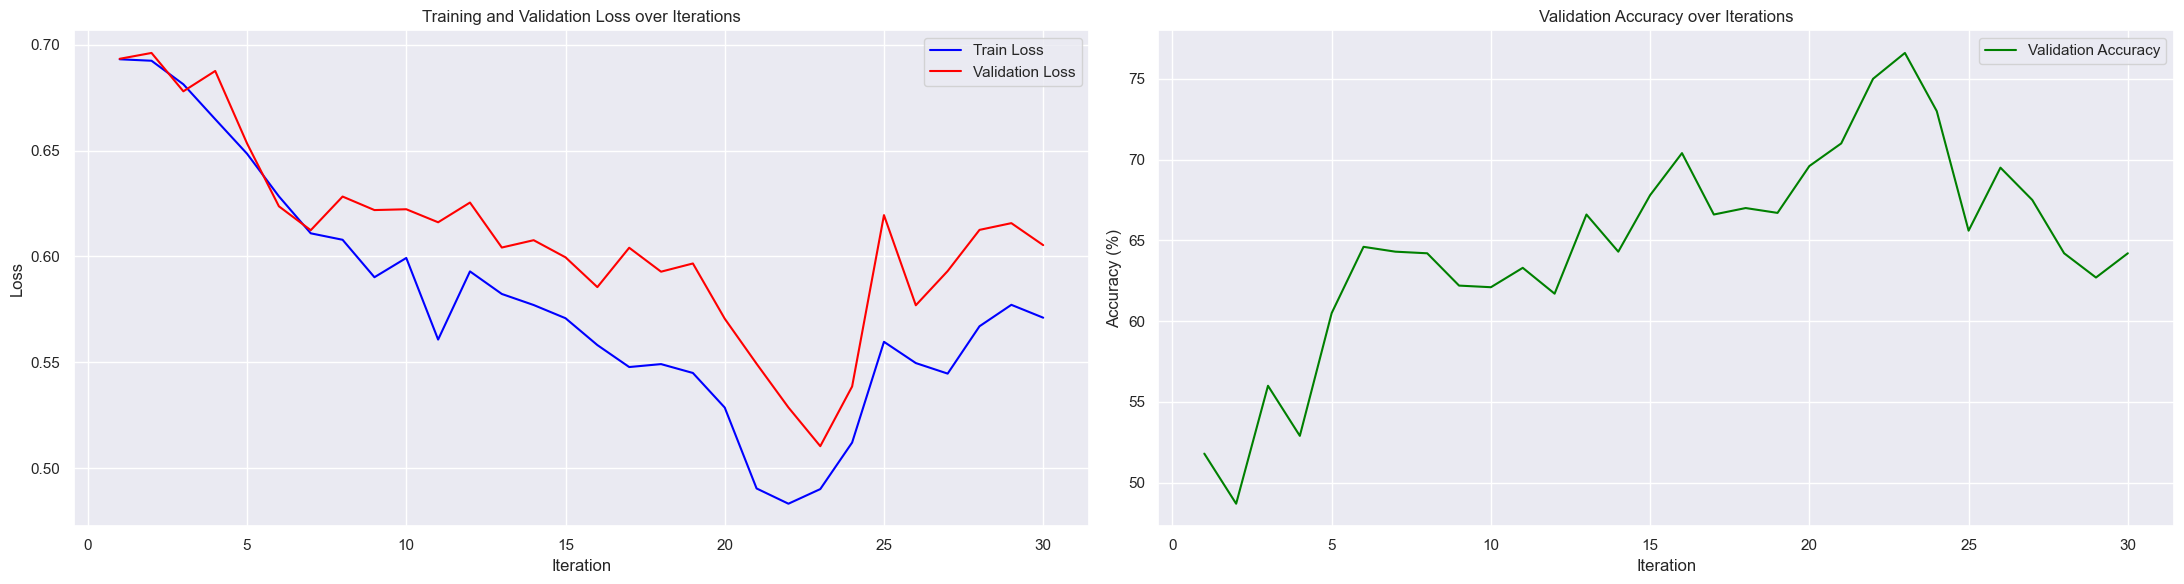

/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

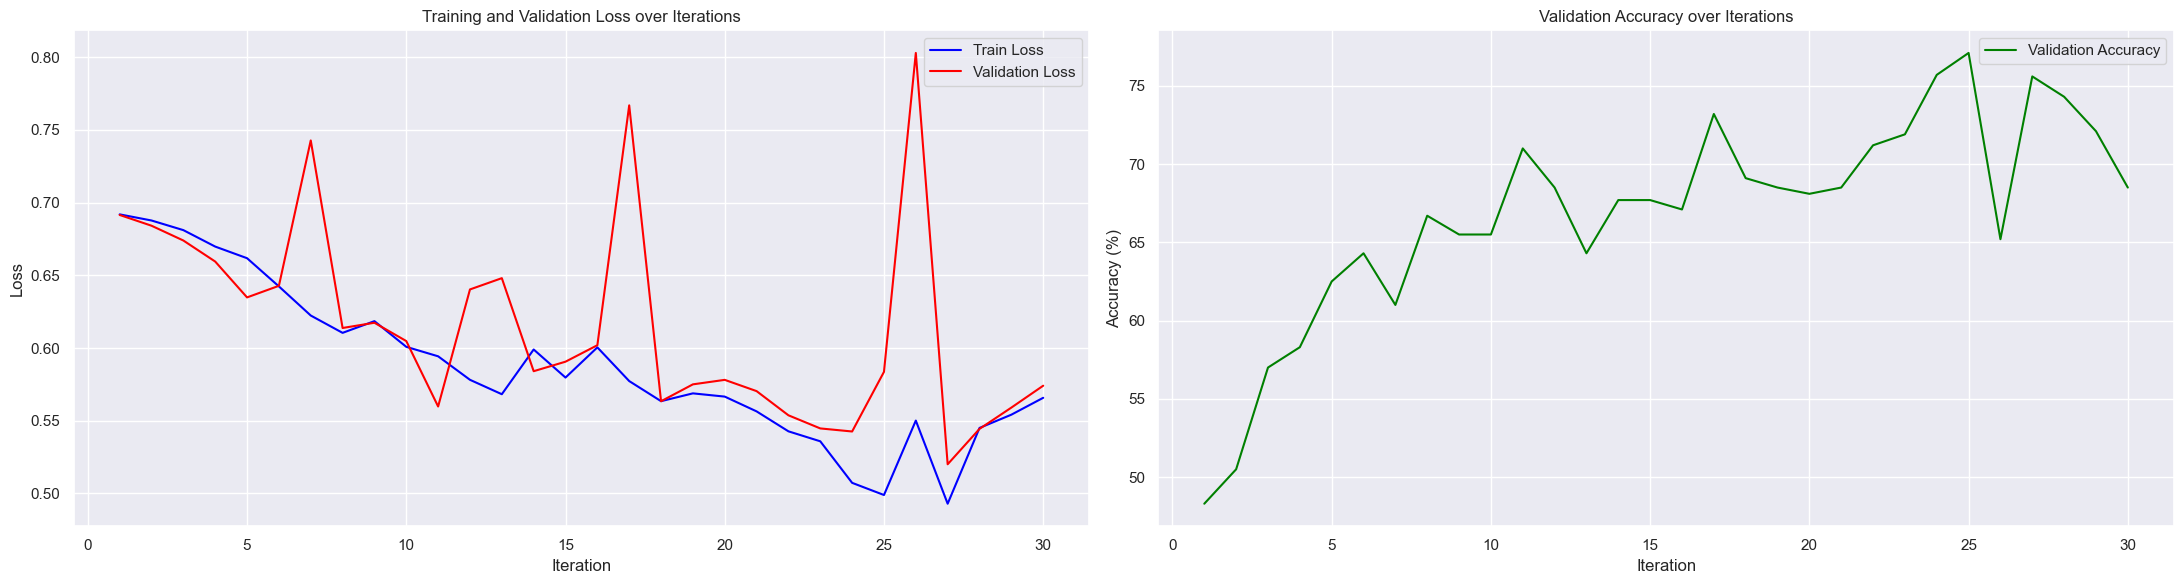

/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

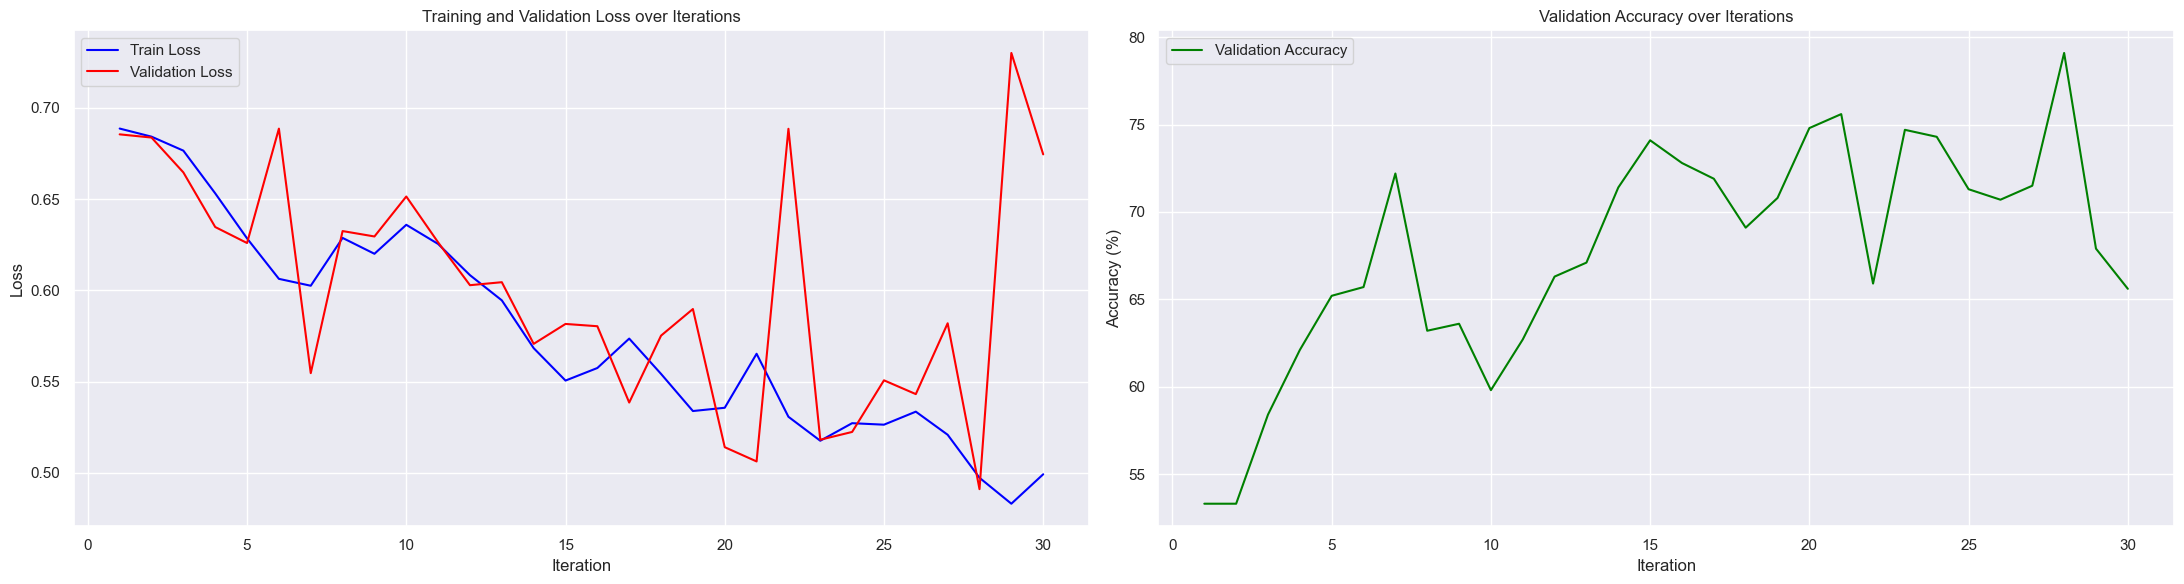

/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

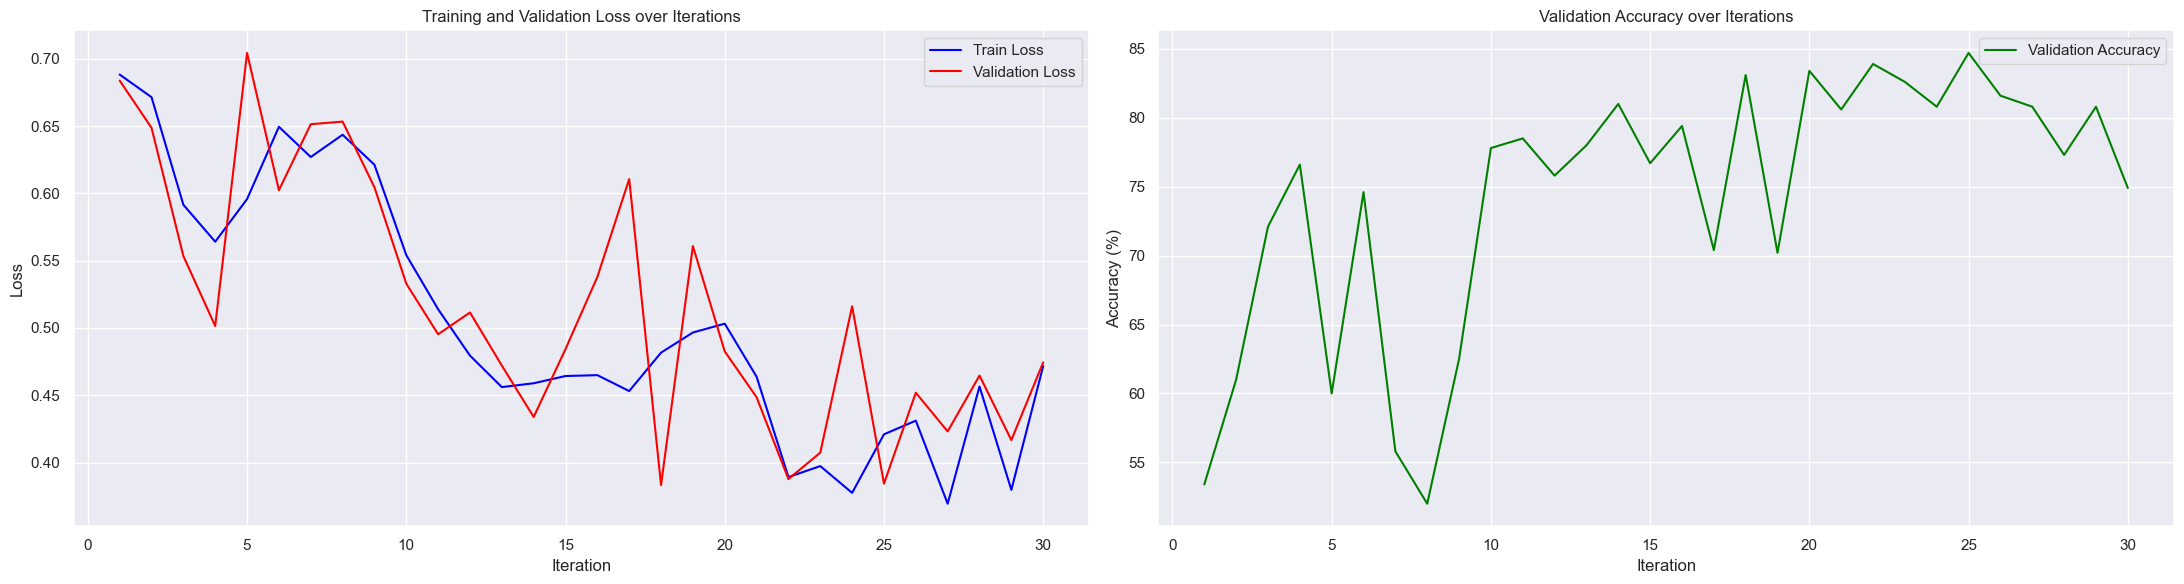

/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

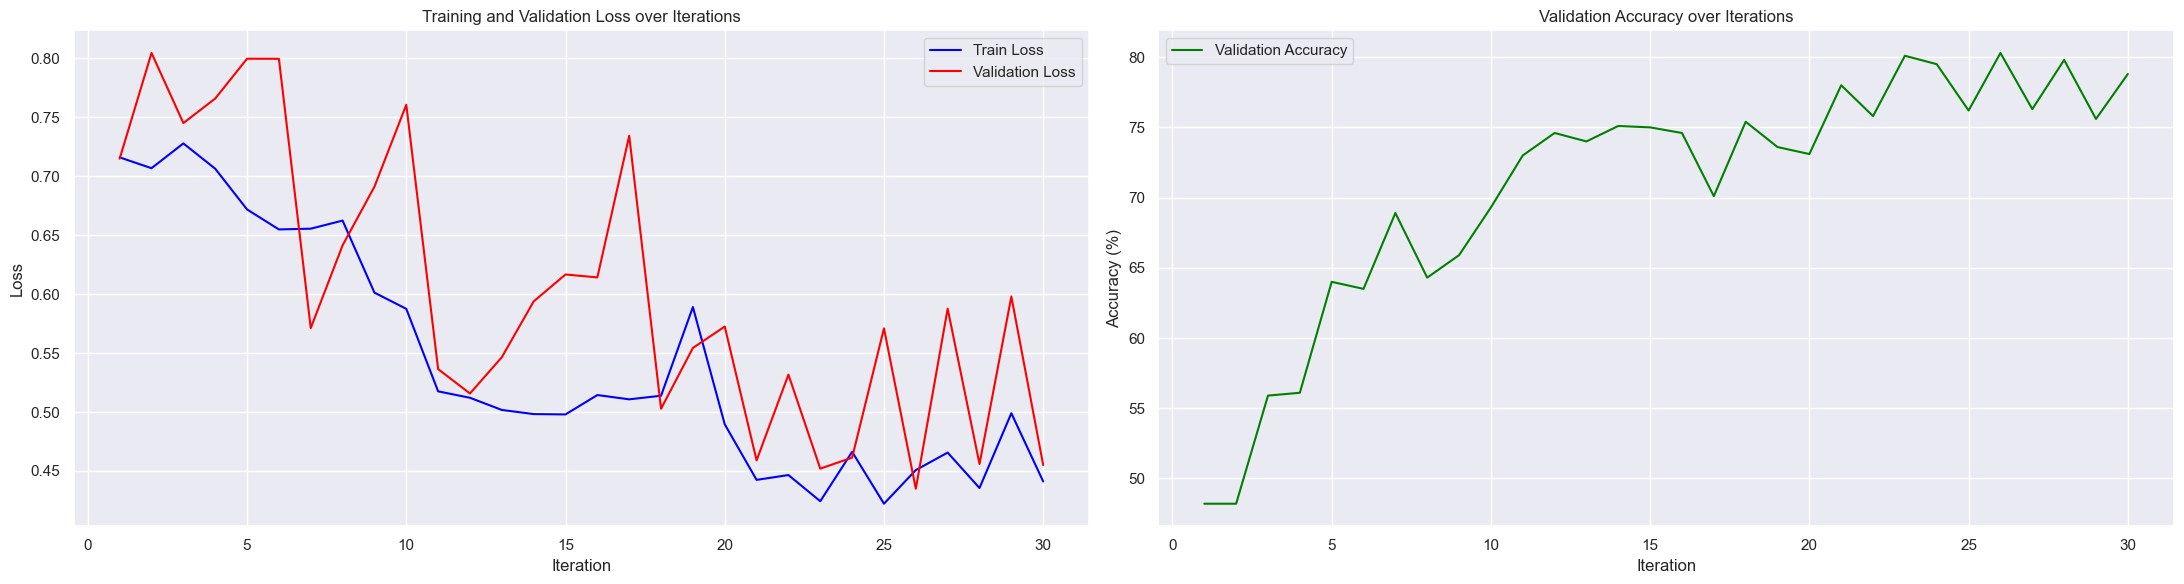

/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

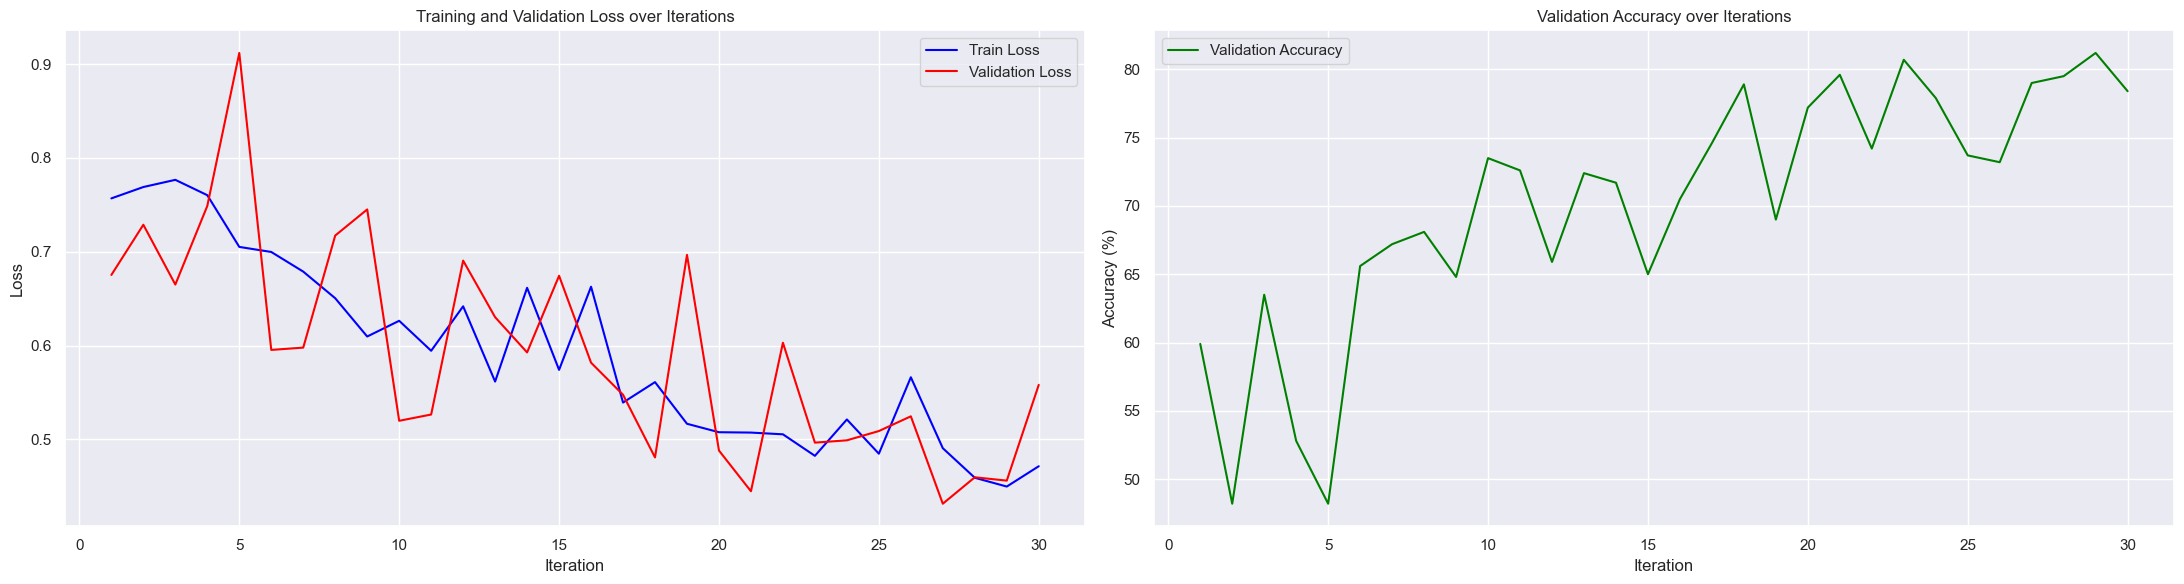

/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

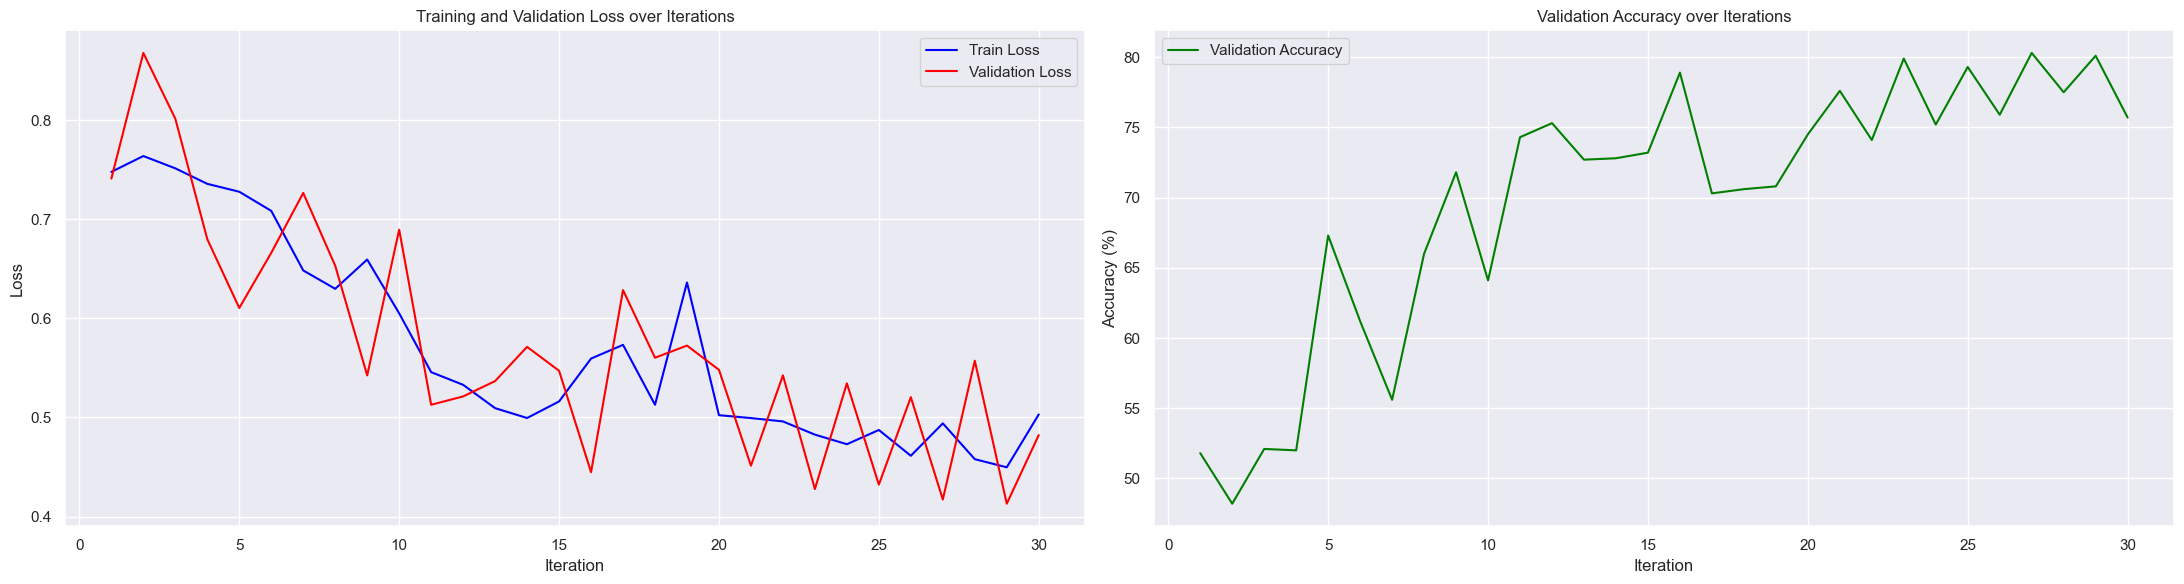

/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maryamalipour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

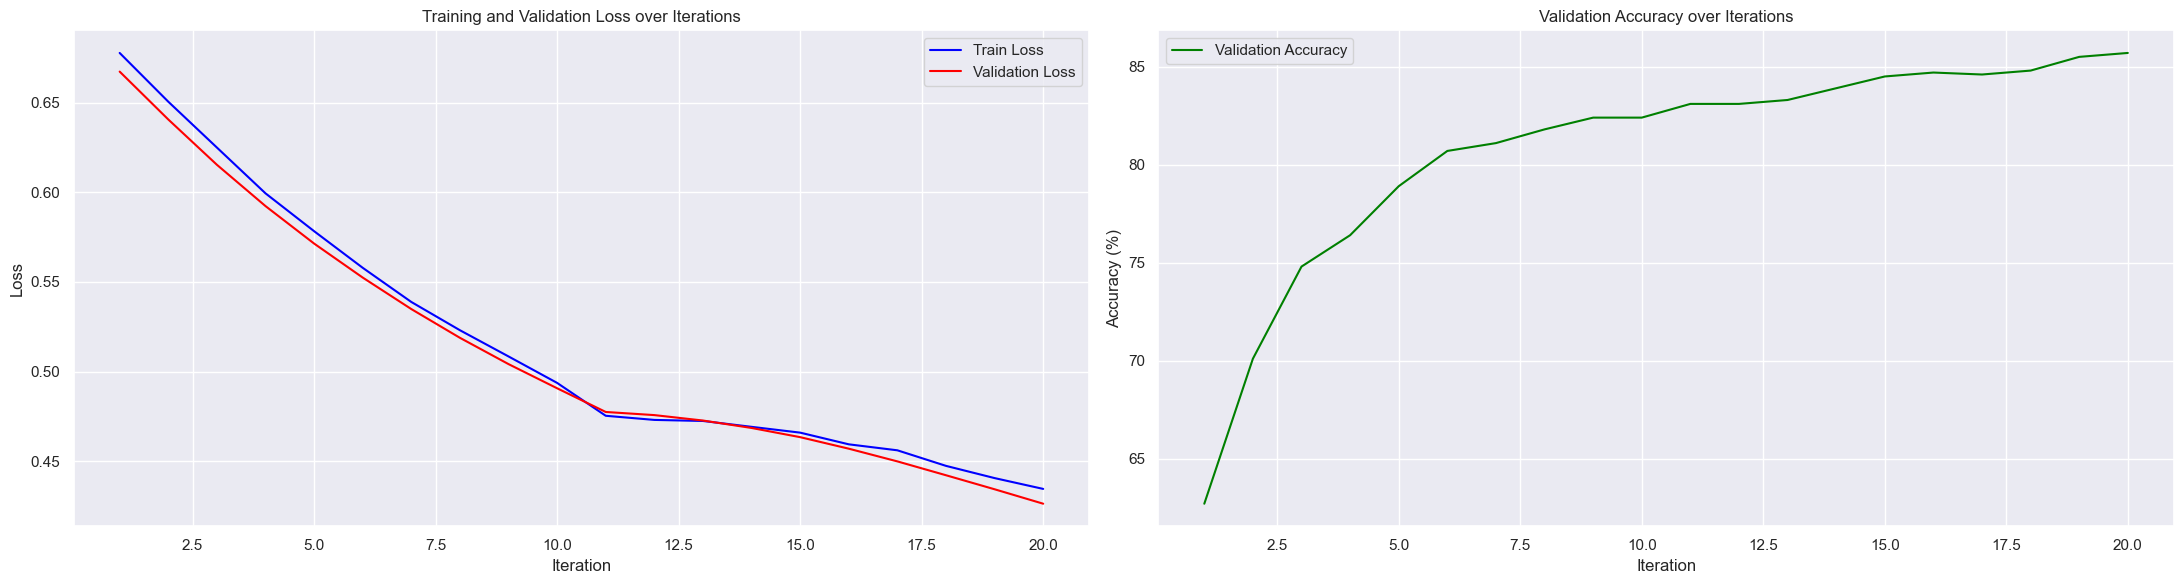

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd

def plot_learning_curves(json_file):
    # Load data from JSON file
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Convert data to suitable format for plotting
    train_losses = data['train_losses']
    eval_losses = data['eval_losses']
    eval_accs = data['eval_accs']

    # Create a DataFrame for loss data
    loss_df = pd.DataFrame({
        'Iteration': range(1, len(train_losses) + 1),
        'Train Loss': train_losses,
        'Validation Loss': eval_losses
    })

    # Create a DataFrame for accuracy data
    acc_df = pd.DataFrame({
        'Iteration': range(1, len(eval_accs) + 1),
        'Validation Accuracy': eval_accs
    })

    # # Plotting
    # sns.set(style='whitegrid')
    # fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # # Losses
    # sns.lineplot(ax=axs[0], x='Iteration', y='Train Loss', data=loss_df, label='Train Loss')
    # sns.lineplot(ax=axs[0], x='Iteration', y='Validation Loss', data=loss_df, label='Validation Loss')
    # axs[0].set_xlabel('Iteration')
    # axs[0].set_ylabel('Loss')
    # axs[0].set_title('Training and Validation Loss over Iterations')
    # axs[0].legend()

    # # Validation Accuracy
    # sns.lineplot(ax=axs[1], x='Iteration', y='Validation Accuracy', data=acc_df, label='Validation Accuracy')
    # axs[1].set_xlabel('Iteration')
    # axs[1].set_ylabel('Accuracy (%)')
    # axs[1].set_title('Validation Accuracy over Iterations')
    # axs[1].legend()

    # # Overall title
    # plt.tight_layout()
    # plt.show()

    # Set a dark grid style for the background
    sns.set(style='darkgrid')
    
    # Create the subplots
    fig, axs = plt.subplots(1, 2, figsize=(22, 6))
    
    # Plot the losses with custom colors
    sns.lineplot(ax=axs[0], x='Iteration', y='Train Loss', data=loss_df, label='Train Loss', color='blue')
    sns.lineplot(ax=axs[0], x='Iteration', y='Validation Loss', data=loss_df, label='Validation Loss', color='red')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Loss over Iterations')
    axs[0].legend()
    
    # Plot the validation accuracy with a custom color
    sns.lineplot(ax=axs[1], x='Iteration', y='Validation Accuracy', data=acc_df, label='Validation Accuracy', color='green')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].set_title('Validation Accuracy over Iterations')
    axs[1].legend()
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Call the function with the path to your JSON file
for i in range(1, 9):
  plot_learning_curves(f'logs/{i}/args.json')

## Q 3.2

In [44]:
import pandas as pd

settings = []
for i in range(1, 9):
    with open(f'logs/{i}/args.json', 'r') as file:
        settings.append(json.load(file))

# Create a list to store the summary for each setting
summary = []

# Extract the relevant information from each setting
for i, setting in enumerate(settings, start=1):
    train_time = sum(setting['epoch_train_time'])
    eval_time = sum(setting['epoch_eval_time'])
    best_eval_acc = max(setting['epoch_eval_acc'])
    eval_f1 = max(setting['epoch_eval_f1'])
    last_eval_loss = setting['epoch_eval_loss'][-1]
    last_train_loss = setting['epoch_train_loss'][-1]
    
    
    summary.append({
        'Experiment': f'Setting {i}',
        'Train Time (s)': round(train_time, 2),
        'Eval Time (s)': round(eval_time, 2),
        'Best Eval Acc (%)': best_eval_acc,
        'Eval F1': round(eval_f1, 2),
        'last Eval Loss': last_eval_loss,
        'Last Train Loss': last_train_loss
    })

# Create a DataFrame and set the Experiment column as the index
summary_df = pd.DataFrame(summary).set_index('Experiment')

print(summary_df)

            Train Time (s)  Eval Time (s)  Best Eval Acc (%)  Eval F1  \
Experiment                                                              
Setting 1           440.83           0.65               69.8     0.67   
Setting 2           440.52           0.64               68.1     0.71   
Setting 3           486.13           0.68               68.0     0.70   
Setting 4           705.05           0.79               86.6     0.86   
Setting 5           737.60           0.82               78.2     0.74   
Setting 6          1123.01           1.05               82.5     0.82   
Setting 7           731.20           0.80               81.3     0.82   
Setting 8          3607.38           6.12               86.4     0.86   

            last Eval Loss  Last Train Loss  
Experiment                                   
Setting 1         0.593365         0.536789  
Setting 2         0.580894         0.537814  
Setting 3         0.667056         0.522535  
Setting 4         0.367904         0.41